# **Comparing MBRL Algorithm Performance on CityLearn**


Loading the code with the related log CSVs and set the graphic output to SVG format.

In [ ]:
%config InlineBackend.figure_format = 'svg'

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


----



Definition of plotting functions for loading and displaying results.

In [43]:
import os
import pandas as pd
import seaborn as sns  # Provides publication-ready themes
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from datetime import datetime

# For downloading files in Google Colab
try:
    from google.colab import files
except ImportError:
    files = None

# Apply a clean Seaborn theme suitable for academic papers
sns.set_theme(style='darkgrid', context='paper')

# Ensure we're in the correct working directory
os.chdir('/content/drive/MyDrive/Colab Notebooks/src/agents/model_based')

# Short-to-display name mappings for each algorithm
ALGO_MAP = {
    'mbpo': 'MBPO',
    'm2ac': 'M2AC',
    'macura': 'MACURA',
    'sac': 'SAC'
}

# Mapping of experiment folder keys to human-readable noise labels
NOISE_MAP = {
    'exp': 'Deterministic',
    'wn_exp': 'White Noise',
    'pn_exp': 'Pink Noise'
}
# Desired ordering of noise types when assigning colors or indexing
NOISE_ORDER = ['Deterministic', 'White Noise', 'Pink Noise']

# Softer, pastel-inspired color palettes per algorithm
COLOR_PALETTES = {
    'MBPO': ['#1f77b4', '#4fa8df', '#89c5f0'],   # blue gradients
    'M2AC': ['#2ca02c', '#6bbf6b', '#9bdd9b'],   # green gradients
    'MACURA': ['#d62728', '#e55a5a', '#f08e8e'], # red gradients
    'SAC': ['#9467bd', '#c5b0d5', '#e0d3eb']     # purple gradients
}



def safe_read_csv(filepath: str) -> pd.DataFrame:
    """
    Safely read a CSV into a DataFrame.
    Returns empty DataFrame if file is missing or empty.
    """
    try:
        return pd.read_csv(filepath)
    except (pd.errors.EmptyDataError, FileNotFoundError):
        return pd.DataFrame()


def load_train(base_dir: str,
               algo: str,
               noise_key: str,
               step_min: int = 0,
               step_freq: int = 1) -> pd.DataFrame:
    """
    Load and preprocess training logs.
    Reads `train.csv` for each algorithm/noise combination,
    filters by step thresholds, labels columns, and prepares
    optional min/max for standard deviation shading.
    """
    if algo == 'sac' and noise_key != 'exp':
        # SAC experiments only use deterministic noise
        return pd.DataFrame()

    filepath = os.path.join(base_dir, algo, 'train.csv')
    df = safe_read_csv(filepath)
    if df.empty or 'step' not in df or 'batch_reward' not in df:
        return pd.DataFrame()

    # Filter and downsample
    df = df[(df['step'] >= step_min) & (df['step'] % step_freq == 0)].copy()
    df['algorithm'] = ALGO_MAP.get(algo, algo)
    df['noise'] = NOISE_MAP.get(noise_key, noise_key)

    # Ensure fallback for shading
    if 'batch_reward_min' not in df:
        df['batch_reward_min'] = df['batch_reward']
    if 'batch_reward_max' not in df:
        df['batch_reward_max'] = df['batch_reward']

    return df[['step', 'batch_reward', 'batch_reward_min', 'batch_reward_max', 'algorithm', 'noise']]


def load_results(base_dir: str,
                 algo: str,
                 step_min: int = 0) -> pd.DataFrame:
    """
    Load episode-level results from `results.csv`, filter by
    minimum env_steps, and label algorithm and noise.
    """
    filepath = os.path.join(base_dir, algo, 'results.csv')
    if not os.path.isfile(filepath):
        return pd.DataFrame()
    df = safe_read_csv(filepath)
    if df.empty or 'env_step' not in df or 'episode_reward' not in df:
        return pd.DataFrame()
    df = df[df['env_step'] >= step_min].copy()
    df['algorithm'] = ALGO_MAP.get(algo, algo)
    df['noise'] = NOISE_MAP.get(os.path.basename(base_dir), 'Unknown')
    return df[['env_step', 'episode_reward', 'algorithm', 'noise']]


def _save_fig(fig: plt.Figure,
              prefix: str,
              save_dir: str = 'figures'):
    """
    Save figure as timestamped SVG to local folder and
    download via Colab's file API.
    """
    os.makedirs(save_dir, exist_ok=True)
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    fname = f"{prefix}_{timestamp}.svg"
    path = os.path.join(save_dir, fname)
    fig.savefig(path, format='svg', bbox_inches='tight')
    if files:
        files.download(path)


def plot_batch_rewards(base_dirs: dict,
                       min_step: int = 0,
                       freq: int = 1,
                       show_std: bool = False,
                       save: bool = False,
                       save_dir: str = 'figures'):
    """
    Plot batch_reward curves for all algorithms and noises provided.
    Note: Passing multiple noise directories will overlay all on one chart.
    - Baseline at y=-12
    - Optional std shading
    - Save/download SVG if `save=True`
    """
    frames = []
    for noise_key, directory in base_dirs.items():
        for algo in os.listdir(directory):
            full = os.path.join(directory, algo)
            if not os.path.isdir(full):
                continue
            df = load_train(directory, algo, noise_key, min_step, freq)
            if not df.empty:
                frames.append(df)
    if not frames:
        print("No training data to plot.")
        return
    all_df = pd.concat(frames, ignore_index=True)
    fig = plt.figure(figsize=(12, 5))
    plt.axhline(-12, color='orange', linestyle='--', linewidth=1, label='CHESCA')
    for (algo, noise), grp in all_df.groupby(['algorithm', 'noise']):
        clr = COLOR_PALETTES[algo][NOISE_ORDER.index(noise)]
        plt.plot(grp['step'], grp['batch_reward'],
                 label=f"{algo} ({noise})", linewidth=1.5, color=clr)
        if show_std:
            plt.fill_between(grp['step'], grp['batch_reward_min'], grp['batch_reward_max'], alpha=0.15, color=clr)
    plt.xlabel('Updates Made')
    plt.ylabel('Batch Reward')
    plt.title('Batch Rewards Across Algorithms & Noises')
    plt.legend(fontsize='small')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    if save:
        _save_fig(fig, 'batch_rewards', save_dir)
    plt.show()


def plot_episode_rewards(base_dirs: dict,
                         min_step: int = 0,
                         save: bool = False,
                         save_dir: str = 'figures'):
    """
    Plot episode_reward over env_step for each algorithm & noise.
    - Baseline at y=-24462
    - Save/download SVG if `save=True`
    """
    frames = []
    for noise_key, directory in base_dirs.items():
        for algo in os.listdir(directory):
            full = os.path.join(directory, algo)
            if not os.path.isdir(full):
                continue
            df = load_results(directory, algo, min_step)
            if not df.empty:
                frames.append(df)
    if not frames:
        print("No episode reward data to plot.")
        return
    all_df = pd.concat(frames, ignore_index=True)
    fig = plt.figure(figsize=(12, 5))
    plt.axhline(-24462, color='orange', linestyle='--', linewidth=1, label='CHESCA')
    for (algo, noise), grp in all_df.groupby(['algorithm', 'noise']):
        clr = COLOR_PALETTES[algo][NOISE_ORDER.index(noise)]
        plt.plot(grp['env_step'], grp['episode_reward'], label=f"{algo} ({noise})", linewidth=1.5, color=clr)
    plt.xlabel('Env Steps')
    plt.ylabel('Episode Reward')
    plt.title('Episode Rewards Across Algorithms & Noises')
    plt.legend(fontsize='small', loc='best')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    if save:
      _save_fig(fig, 'evaluate_rew', save_dir)
    plt.show()


def build_rewards_summary_table(base_dirs: dict,
                                min_step: int = 0) -> pd.DataFrame:
    """
    Summarize final episode rewards in a pivot table:
      rows = noise types, columns = algorithms.
    """
    records = []
    for noise_key, directory in base_dirs.items():
        for algo in os.listdir(directory):
            full = os.path.join(directory, algo)
            if not os.path.isdir(full): continue
            df = load_results(directory, algo, min_step)
            if not df.empty:
                rec = df.loc[df['env_step'].idxmax()]
                records.append(rec)
    if not records:
        print("No results data available.")
        return pd.DataFrame()
    summary = pd.DataFrame(records)
    pivot = summary.pivot(index='noise', columns='algorithm', values='episode_reward')
    display(Markdown("**Final Episode Reward by Noise & Method**"))
    display(Markdown(pivot.reset_index().to_markdown(floatfmt='.2f')))
    return pivot

# Deterministic Noise (Batch Reward)
----

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

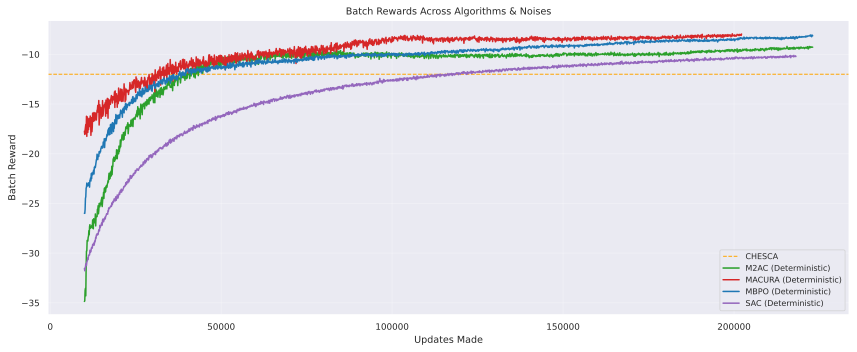

# Final Evaluated Episode Reward
----

**Final Episode Reward by Noise & Method**

|    | noise         |      M2AC |    MACURA |      MBPO |       SAC |
|---:|:--------------|----------:|----------:|----------:|----------:|
|  0 | Deterministic | -15310.12 | -16789.39 | -20368.27 | -17343.59 |

# Episode Reward Across Algorithms & Noises
----

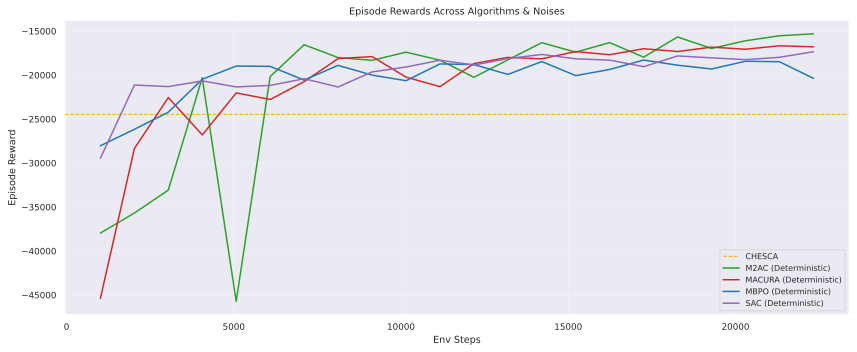

In [45]:
# === MAIN EXECUTION ===
# Define base directories for each noise type
base_dirs = {
    'exp': './exp',       # Deterministic noise
    'wn_exp': './wn_exp', # White Noise
    'pn_exp': './pn_exp'  # Pink Noise
}

# Note: previous plotting functions can accept multiple noise types
# simply by passing a dict containing more than one key in base_dirs.

# 1) Batch reward curves for deterministic noise only
display(Markdown("# Deterministic Noise (Batch Reward)\n----"))
plot_batch_rewards({'exp': base_dirs['exp']}, min_step=10000, freq=100, show_std=False, save=True)

# 2) Summary table of final episode rewards across all noises

display(Markdown("# Final Evaluated Episode Reward\n----"))
df_summary = build_rewards_summary_table(base_dirs)

# 3) Episode reward curves across all algorithms & noises

display(Markdown("# Episode Reward Across Algorithms & Noises\n----"))
plot_episode_rewards(base_dirs, save=False)
